In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>=year_ago).order_by(Measurement.date.desc()).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns=['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [15]:
prcp_df['Precipitation'].isnull().sum()

209

![precipitation](Images/precipitation.png)

In [16]:
prcp_df=prcp_df.dropna()
prcp_df['Precipitation'].isnull().sum()

0

In [ ]:
prcp_df.head()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


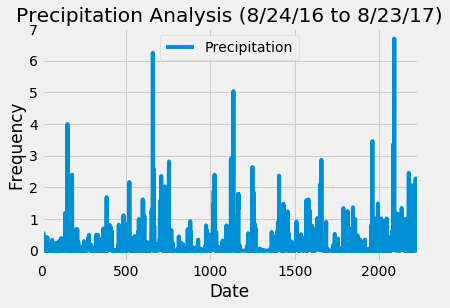

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data 
ax = prcp_df.plot()
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
plt.show()

![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [22]:
count=func.count(Measurement.station)

In [23]:
session.query(Measurement.station).group_by(Measurement.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station,count).\
         group_by(Measurement.station).\
         order_by(count.desc()).all()
# List the stations and the counts in descending order.
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
most_active = session.query(Measurement.station,count).group_by(Measurement.station).order_by(count.desc()).first()

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = func.min(Measurement.tobs)
high_temp = func.max(Measurement.tobs)
avg_temp = func.avg(Measurement.tobs)
session.query(low_temp,high_temp,avg_temp).filter(Measurement.station == most_active[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [27]:
# Choose the station with the highest number of temperature observations.
tobs_date = session.query(Measurement.date).\
filter(Measurement.station == most_active[0]).\
order_by(Measurement.date.desc()).first()
tobs_date

('2017-08-18')

![precipitation](Images/station-histogram.png)

In [28]:
tobs_yr_ago = dt.date(2017,8,18) - dt.timedelta(days=365)
tobs_yr_ago

datetime.date(2016, 8, 18)

In [29]:
tobs_query = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date>tobs_yr_ago).\
filter(Measurement.station == most_active[0]).all()

In [30]:
tobs_df = pd.DataFrame(tobs_query, columns=['Date', 'Temp Obs'])
tobs_df.head()

,Date,Temp Obs
0,2016-08-19,79.0
1,2016-08-20,81.0
2,2016-08-21,79.0
3,2016-08-22,78.0
4,2016-08-23,77.0


In [31]:
tobs_df['Temp Obs'].isnull().sum()

0

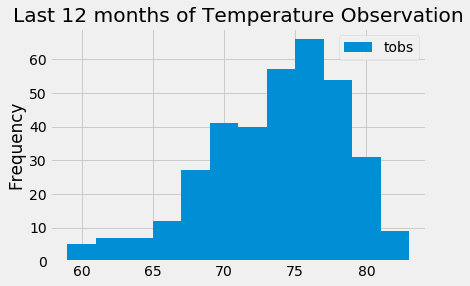

In [32]:
#plot the results as a histogram
tobs_df.hist(bins=12)
plt.title("Last 12 months of Temperature Observation")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
